In [148]:
#import depedencies
import numpy as np
import pandas as pd
import requests
from datetime import datetime
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Retrieve Data


In [149]:
with open('pass.txt', 'r') as f:
    lines = f.readlines()

pwd = lines[0].strip()
CLIENT_ID = lines[1].strip()
SECRET_ID = lines[2].strip()

Get necessary credentials in order to use API

In [150]:
data = {
    'grant_type': 'password',
    'username': 'eJechtion4',
    'password': pwd
}
headers = {"User-Agent": "MyAPI/1.0.0"}
auth = requests.auth.HTTPBasicAuth(CLIENT_ID, SECRET_ID)

res = requests.post('https://www.reddit.com/api/v1/access_token',
auth = auth, data = data, headers = headers)

TOKEN = res.json()["access_token"]
headers["Authorization"] = f'bearer {TOKEN}'


In [151]:
res = requests.get("https://oauth.reddit.com/r/AskReddit/hot", headers = headers, params= {'limit': '100'})

In [152]:
# Extract relevant data from API response
data = []
for post in res.json()["data"]["children"]:
    post_date = datetime.utcfromtimestamp(post["data"]["created_utc"]).strftime('%Y-%m-%d %H:%M:%S')
    data.append({
        "post_id": post["data"]["id"],
        "post_title": post["data"]["title"],
        "post_text": post["data"]["selftext"],
        "post_date": post_date,
        "author": post["data"]["author"],
        "subreddit": post["data"]["subreddit"],
        "upvotes": post["data"]["ups"],
        "downvotes": post["data"]["downs"],
        "num_comments": post["data"]["num_comments"]
    })

# Create pandas DataFrame from extracted data
df = pd.DataFrame(data)

Retrieve data from the Reddit by using Reddit's API. The API data is retrieved by making a POST request to the API using the requests library, and then extracting relevant data. The data retrieved is from the subreddit "AskReddit" which is a subreddit of primarly asking a variety of questions.

# Clean Data

In [153]:
print(df.duplicated().sum()) #check for duplicates
df.drop_duplicates(subset=['post_title', 'post_text'], inplace=True) #drop duplicates
df

0


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   post_id       101 non-null    object
 1   post_title    101 non-null    object
 2   post_text     101 non-null    object
 3   post_date     101 non-null    object
 4   author        101 non-null    object
 5   subreddit     101 non-null    object
 6   upvotes       101 non-null    int64 
 7   downvotes     101 non-null    int64 
 8   num_comments  101 non-null    int64 
dtypes: int64(3), object(6)
memory usage: 5.5+ KB


In [157]:
#Remove puncutation from post title for better analysis later on
import re

# define a function to remove punctuation from a string
def remove_punctuation(text):
    return re.sub(r'[^\w\s]','',text)

# remove punctuation from the "post_title" column
df_no_punct = df.copy()
df_no_punct['post_title'] = df_no_punct['post_title'].apply(remove_punctuation)


In [158]:
df_no_punct

,post_id,post_title,post_text,post_date,author,subreddit,upvotes,downvotes,num_comments
0,11kyi0b,Which one of these charities should AskReddit ...,It's time for the community to vote on which c...,2023-03-07 12:49:22,-eDgAR-,AskReddit,133,0,6
1,11nujza,You find a wallet with 300 in it What do you f...,,2023-03-10 17:01:47,SolutionIsEducation,AskReddit,5282,0,4150
2,11nt5w1,People of Reddit what is the dumbest reason yo...,,2023-03-10 16:08:27,Starboy3210,AskReddit,2129,0,1889
3,11nqkcm,If instead of men women were inherently physic...,,2023-03-10 14:23:57,Tototorrin,AskReddit,1215,0,1332
4,11nmzgf,What food has the worst texture,,2023-03-10 11:48:32,Lille_Ana,AskReddit,1351,0,3328
...,...,...,...,...,...,...,...,...,...
96,11o4j64,What is the longest you have ever went without...,,2023-03-10 23:34:58,Puzzleheaded-Pen9047,AskReddit,3,0,10
97,11o4hde,Reddit what are some unethical ways to make money,,2023-03-10 23:32:54,macanddogs,AskReddit,3,0,12
98,11o4h09,What do you put cheese on,,2023-03-10 23:32:28,Puzzleheaded-Pen9047,AskReddit,3,0,18
99,11o4gew,What are some good hacks and survival tricks f...,,2023-03-10 23:31:44,Shamanofthealike1,AskReddit,3,0,5


We had to remove punctuation has it was interfering with some data analysis. By removing these punctuation we hope to improve the accuracy of our results.

# NLP Start


In [160]:
# define stop words
stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# define preprocessing pipeline
def preprocess_text(text):
    # tokenize text
    tokens = word_tokenize(text)

    # remove stop words
    tokens = [token for token in tokens if token not in stop_words]

    # stem and lemmatize tokens
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]

    # return preprocessed text as a string
    return " ".join(lemmatized_tokens)




We utlized stop words from the nltk library after which we preprocessed the important texts along with stemming them and lemmatizing them. 

In [161]:
# apply preprocessing pipeline to text data
df_no_punct["preprocessed_text"] = df_no_punct["post_title"].apply(preprocess_text)

In [162]:
df_no_punct["preprocessed_text"] # check if stemming worked

0      which one chariti askreddit support 15th anniv...
1      you find wallet 300 what find wallet make keep...
2      peopl reddit dumbest reason ex partner gave cheat
3      if instead men woman inher physic stronger wou...
4                                 what food worst textur
                             ...                        
96                    what longest ever went without eat
97                           reddit uneth way make money
98                                        what put chees
99     what good hack surviv trick someon live someon...
100                        which video game legit addict
Name: preprocessed_text, Length: 101, dtype: object

# Vectorize data


We want to convert text into numberical data so that we can use machine learning algorithims on it. Vectorization also helps in reducing the dimentionality of the data which can improve effciency.

In [163]:
# create a CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=1000)

# fit and transform the preprocessed_text column
X = vectorizer.fit_transform(df_no_punct["preprocessed_text"])

# create a new dataframe with the countvectorizer output
cv_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# concatenate the cv_df dataframe with the original dataframe
df_final = pd.concat([df_no_punct, cv_df], axis=1)

In [164]:
df_final

,post_id,post_title,post_text,post_date,author,subreddit,upvotes,downvotes,num_comments,preprocessed_text,...,wikipedia,wish,wit,woman,work,world,worst,year,youv,zombi
0,11kyi0b,Which one of these charities should AskReddit ...,It's time for the community to vote on which c...,2023-03-07 12:49:22,-eDgAR-,AskReddit,133,0,6,which one chariti askreddit support 15th anniv...,...,0,0,0,0,0,0,0,0,0,0
1,11nujza,You find a wallet with 300 in it What do you f...,,2023-03-10 17:01:47,SolutionIsEducation,AskReddit,5282,0,4150,you find wallet 300 what find wallet make keep...,...,0,0,0,0,0,0,0,0,0,0
2,11nt5w1,People of Reddit what is the dumbest reason yo...,,2023-03-10 16:08:27,Starboy3210,AskReddit,2129,0,1889,peopl reddit dumbest reason ex partner gave cheat,...,0,0,0,0,0,0,0,0,0,0
3,11nqkcm,If instead of men women were inherently physic...,,2023-03-10 14:23:57,Tototorrin,AskReddit,1215,0,1332,if instead men woman inher physic stronger wou...,...,0,0,0,1,0,0,0,0,0,0
4,11nmzgf,What food has the worst texture,,2023-03-10 11:48:32,Lille_Ana,AskReddit,1351,0,3328,what food worst textur,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,11o4j64,What is the longest you have ever went without...,,2023-03-10 23:34:58,Puzzleheaded-Pen9047,AskReddit,3,0,10,what longest ever went without eat,...,0,0,0,0,0,0,0,0,0,0
97,11o4hde,Reddit what are some unethical ways to make money,,2023-03-10 23:32:54,macanddogs,AskReddit,3,0,12,reddit uneth way make money,...,0,0,0,0,0,0,0,0,0,0
98,11o4h09,What do you put cheese on,,2023-03-10 23:32:28,Puzzleheaded-Pen9047,AskReddit,3,0,18,what put chees,...,0,0,0,0,0,0,0,0,0,0
99,11o4gew,What are some good hacks and survival tricks f...,,2023-03-10 23:31:44,Shamanofthealike1,AskReddit,3,0,5,what good hack surviv trick someon live someon...,...,0,0,0,0,0,0,0,0,0,0


# Data Exploration (EDA)

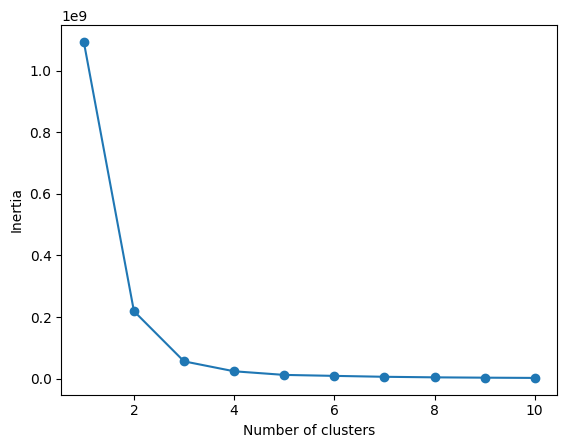

In [165]:
#Use unspervised learning methods to categorize each post, in this case we will be using KMEANs
#First we will use the elbow method in order to determine the ideal number of clusters for our data


# concatenate the vectorized text features, upvotes, and number of comments
df_elbow = df_final.drop(["post_id", "post_title", "post_text", "post_date", "author", "subreddit", "preprocessed_text"], axis=1)

# perform k-means clustering for different number of clusters and calculate the inertia for each
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_elbow)
    inertia.append(kmeans.inertia_)

# plot the elbow curve to visualize the results
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


The elbow method suggests selecting the number of clusters where the inertia starts to level off. In our case, it appears that three clusters would be the ideal number.

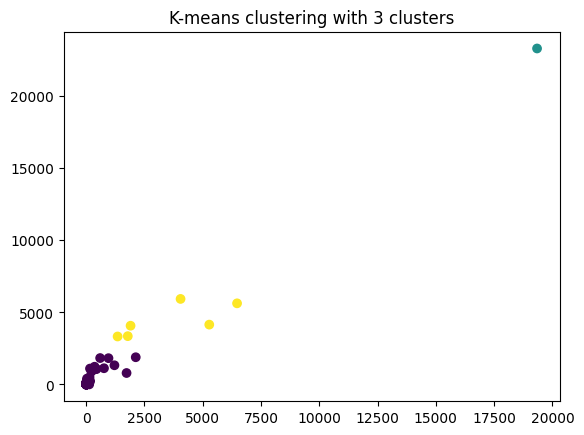

In [166]:
# Perform K-means clustering with 3 clusters
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(df_elbow)
labels_3 = kmeans_3.labels_

# Visualize the clusters
plt.scatter(df_elbow['upvotes'], df_elbow['num_comments'], c=labels_3)
plt.title("K-means clustering with 3 clusters")
plt.show()


We perform k-means clustering on the preprocessed text, upvotes, and number of comments columns with three clusters. We plot the clusters based on the upvotes and number of comments. However, there seems to be an outlier that is impacting our results. Therefore, we will remove the outlier.

# Removing Outlier and reperforming Kmeans


In [167]:
outlier = df_elbow.loc[df_elbow['num_comments'].idxmax()]# Find the outlier based on the graph it seems to be at the max
print(outlier)

upvotes         19339
downvotes           0
num_comments    23291
1000000             0
12                  0
                ...  
world               0
worst               0
year                0
youv                0
zombi               0
Name: 12, Length: 324, dtype: int64


In [168]:
# Find the index of the row corresponding to the outlier post
outlier_index = df_final[df_final["post_id"] == "11mv4dc"].index[0]

# Drop the row from the dataframe
df_final_no_outlier = df_final.drop(outlier_index)


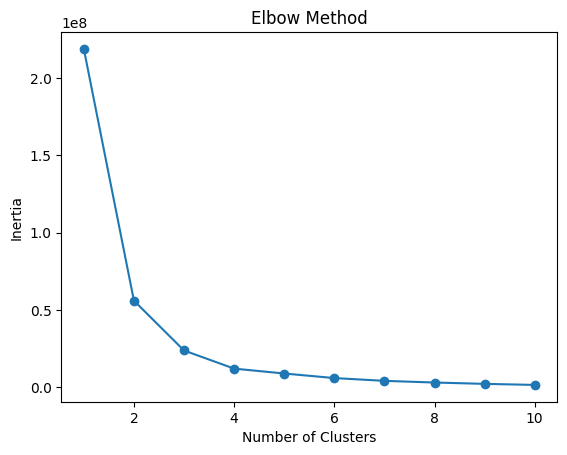

In [169]:
df_elbow_clean = df_final_no_outlier.drop(["post_id", "post_title", "post_text", "post_date", "author", "subreddit", "preprocessed_text"], axis=1)


# Perform elbow method on updated data frame
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_elbow_clean)
    inertias.append(kmeans.inertia_)

# Plot elbow method results
plt.plot(range(1, 11), inertias,marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

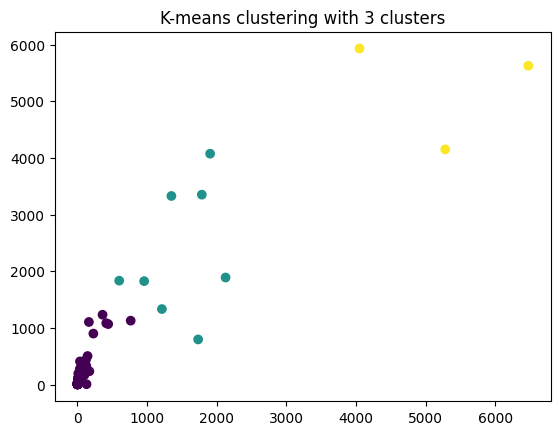

In [170]:
# Perform K-means clustering with 3 clusters
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(df_elbow_clean)
labels_3 = kmeans_3.labels_

# Visualize the clusters
plt.scatter(df_elbow_clean['upvotes'], df_elbow_clean['num_comments'], c=labels_3)
plt.title("K-means clustering with 3 clusters")
plt.show()


In [171]:
# Add the cluster labels to the dataframe
df_final_no_outlier["cluster"] = labels_3
# Compute the mean values of the upvotes, downvotes, and number of comments for each cluster
df_final_no_outlier.groupby("cluster").mean()[["upvotes", "downvotes", "num_comments"]]


,upvotes,downvotes,num_comments
cluster,,,
0,46.707865,0.0,140.415730
1,1460.875000,0.0,2303.500000
2,5269.000000,0.0,5235.666667


In [172]:
df_final_no_outlier.groupby("cluster").median()[["upvotes", "downvotes", "num_comments"]]

,upvotes,downvotes,num_comments
cluster,,,
0,6.0,0.0,18.0
1,1543.0,0.0,1861.0
2,5282.0,0.0,5626.0


Cluster 2 seems to have the most amount of interation with high number of upvotes as well as number of comments. Cluster 1 also has decent amoung of upvotes and number of comments showing good interation from the community. These two clusters can be contrated with cluster 0 with fewer number of upvotes being in the single digits and small amount of interation with a low amount of comments

In [173]:
# Define a function to get the most common words in each cluster
def get_top_words(cluster, n_top_words=10):
    cluster_df = df_final_no_outlier[df_final_no_outlier["cluster"] == cluster]
    text = " ".join(cluster_df["preprocessed_text"].tolist())
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    freq_dist = nltk.FreqDist(tokens)
    top_words = freq_dist.most_common(n_top_words)
    return [word for word, count in top_words]

# Print the most common words in each cluster
for cluster in range(3):
    print(f"Cluster {cluster}: {get_top_words(cluster)}")


Cluster 0: ['thing', 'would', 'ever', 'peopl', 'realli', 'make', 'worst', 'game', 'someth', 'feel']
Cluster 1: ['would', 'ruin', 'peopl', 'reddit', 'dumbest', 'reason', 'ex', 'partner', 'gave', 'cheat']
Cluster 2: ['find', 'wallet', '300', 'make', 'keep', 'money', 'nonreligi', 'equival', 'amen', 'best']


For cluster 0, this cluster seems to be focused on general observations about things and people, with words like "thing", "people", "make", and "feel". Whilist for cluster 1 seems to be focused on relationships, with words like "ruin", "partner", and "cheat". For cluster 2 it seems to be focused on financial or practical matters, with words like "wallet", and "money", with the inclusion of "nonreligious" and "amen", further suggesting spiritual or philosophical questions.

In [174]:
df_final_no_outlier["cluster"].value_counts()

0    89
1     8
2     3
Name: cluster, dtype: int64

Most posts seem to be under cluster 0, which suggests that these posts were similar in terms of their content. Cluster 1 contains only 8 posts, while cluster 2 contains only 3 posts, indicating that the topics of these posts were relatively distinct from the majority of the posts in the dataset.

In [175]:
text_data = df_final_no_outlier["post_title"]

In [176]:
# initialize sentiment analyzer
sid = SentimentIntensityAnalyzer()

# perform sentiment analysis on each post title in the text data
sentiment_scores = text_data.apply(sid.polarity_scores)

# print the sentiment scores
print(sentiment_scores)


0      {'neg': 0.0, 'neu': 0.558, 'pos': 0.442, 'comp...
1      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2      {'neg': 0.365, 'neu': 0.635, 'pos': 0.0, 'comp...
3      {'neg': 0.0, 'neu': 0.822, 'pos': 0.178, 'comp...
4      {'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'comp...
                             ...                        
96     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
97     {'neg': 0.292, 'neu': 0.708, 'pos': 0.0, 'comp...
98     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
99     {'neg': 0.067, 'neu': 0.804, 'pos': 0.129, 'co...
100    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: post_title, Length: 100, dtype: object


In [177]:
compound_scores = [score['compound'] for score in sentiment_scores]
average_compound_score = sum(compound_scores) / len(compound_scores)
print("Average compound score:", average_compound_score)


Average compound score: 0.06652499999999999


Based on the average compound score of 0.066525, we can say that the overall sentiment of post titles in the hot section is slightly positive.

In [178]:
# Get the list of compound scores from the sentiment_scores dictionary
compound_scores = [score['compound'] for score in sentiment_scores]

# Calculate the median score using numpy
median_score = np.median(compound_scores)

print('Median compound score:', median_score)

Median compound score: 0.0


Based on the median compound score there are likely an equal number of positive and negative posts in the dataset, and that the overall sentiment is not strongly positive or negative

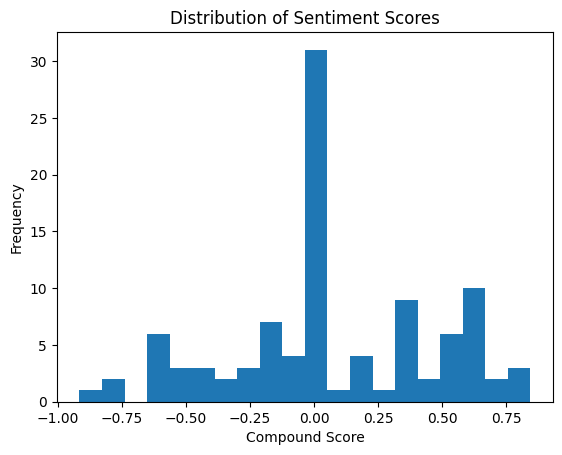

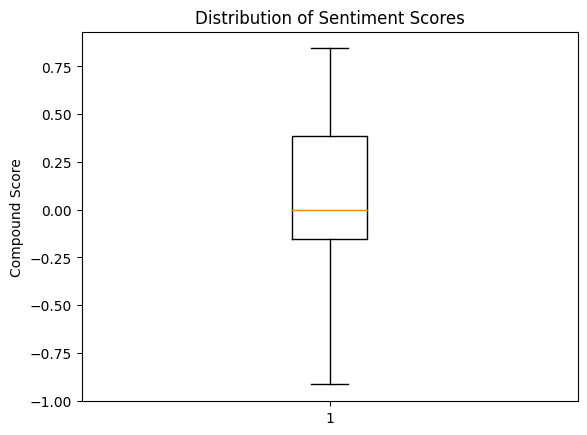

In [179]:
import matplotlib.pyplot as plt

# extract the compound scores
compound_scores = [score['compound'] for score in sentiment_scores]

# plot a histogram of the compound scores
plt.hist(compound_scores, bins=20)
plt.xlabel("Compound Score")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiment Scores")
plt.show()

# plot a box plot of the compound scores
plt.boxplot(compound_scores)
plt.ylabel("Compound Score")
plt.title("Distribution of Sentiment Scores")
plt.show()


This sentiment analysis is not surprising as most of the posts are simply questions from the subreddit AskReddit which should be mostly neutral or slightly postive.